<a href="https://colab.research.google.com/github/Ahmed-Jishan/TikTacToe/blob/main/Braintumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data = '/content/gdrive/MyDrive/brain_tumor_dataset'
No_brain_tumor = '/content/gdrive/MyDrive/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/gdrive/MyDrive/brain_tumor_dataset/yes'

In [9]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5712    labels:  5712


In [11]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(5712,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/gdrive/MyDrive/brain_tumor_dataset/no...,No
1,/content/gdrive/MyDrive/brain_tumor_dataset/no...,No
2,/content/gdrive/MyDrive/brain_tumor_dataset/no...,No
3,/content/gdrive/MyDrive/brain_tumor_dataset/no...,No
4,/content/gdrive/MyDrive/brain_tumor_dataset/no...,No


In [12]:
print(df['labels'].value_counts())

Yes    4118
No     1594
Name: labels, dtype: int64


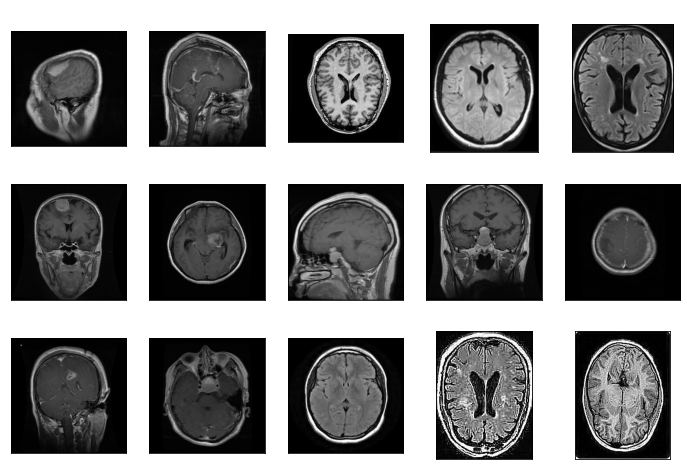

In [13]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (4883, 2)
test set shape: (286, 2)
validation set shape: (543, 2)


In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [16]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 4883 validated image filenames belonging to 2 classes.
Found 543 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.


In [17]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [18]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization_203 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 128)               

In [19]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
306/306 [==============================] - 2589s 8s/step - loss: 0.2132 - accuracy: 0.9285 - val_loss: 0.1104 - val_accuracy: 0.9742
Epoch 2/40
306/306 [==============================] - 2532s 8s/step - loss: 0.1132 - accuracy: 0.9689 - val_loss: 0.0258 - val_accuracy: 0.9963
Epoch 3/40
306/306 [==============================] - 2533s 8s/step - loss: 0.0860 - accuracy: 0.9742 - val_loss: 4.5795 - val_accuracy: 0.9926
Epoch 4/40
306/306 [==============================] - 2536s 8s/step - loss: 0.0685 - accuracy: 0.9818 - val_loss: 0.0308 - val_accuracy: 0.9945
Epoch 5/40
306/306 [==============================] - 2510s 8s/step - loss: 0.0755 - accuracy: 0.9801 - val_loss: 16.8641 - val_accuracy: 0.9853
Epoch 5: early stopping


In [20]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

18/18 [==============================] - 53s 3s/step - loss: 1.3476 - accuracy: 0.9825


[1.3475620746612549, 0.9825174808502197]

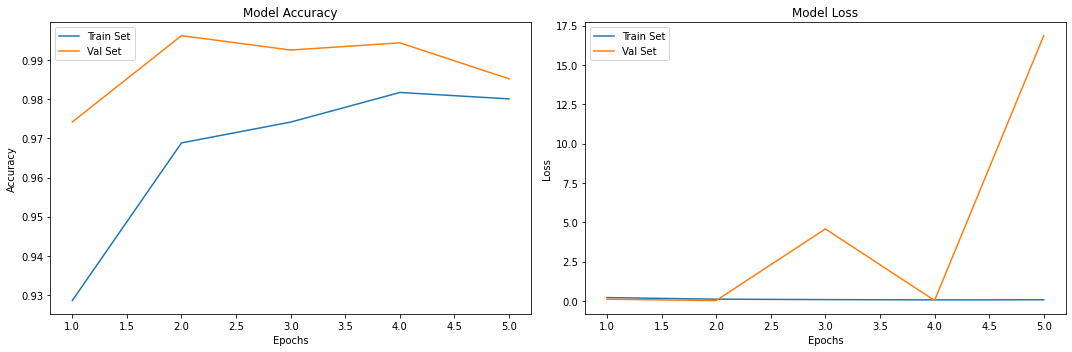

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()